In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import os

os.chdir("..")
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [3]:
import torch
from permacache import stable_hash

import frame_alignment_checks as fac
from matplotlib import pyplot as plt

from render_psam import render_psams, render_psam

from orthogonal_dfa.data.exon import default_exon
from orthogonal_dfa.manual_dfa.splice_site_dfa import splice_site_psam_pdfa
from orthogonal_dfa.psams.psam_pdfa import PSAMPDFA, PSAMPDFAWithTemperature
from orthogonal_dfa.psams.train import (
    identify_first_best_by_validation,
    train_psam_pdfa_full_learning_curve,
)
from orthogonal_dfa.spliceai.load_model import load_spliceai
from orthogonal_dfa.oracle.run_model import create_dataset
from orthogonal_dfa.experiments.train_from_scratch import *
from orthogonal_dfa.module.residual_gate import *
from orthogonal_dfa.experiments.train_gate import (
    evaluate,
    train,
    train_multiple,
    evaluate_multiple,
    plot_linear_psam_gate,
    plot_pdfa,
)
from orthogonal_dfa.experiments.gate_experiments import (
    train_mll,
    train_psam_linear,
    train_psamdfa,
)
from orthogonal_dfa.manual_dfa.stop_codon_dfa import (
    stop_codon_from_psams,
    stop_codon_psamdfa,
    ZeroProbability,
)

In [4]:
def train_pdfa_wrt(test_dfa, control_gates):
    torch.manual_seed(0)
    gate, _ = train(
        InputMonotonicModelingGate(test_dfa, 5, 100).cuda(),
        1e-2,
        default_exon,
        oracle(),
        control_gates,
        epochs=10,
        batch_size=1000,
        train_count=100_000,
        seed=0,
        do_not_train_phi=True,
    )
    end, start = evaluate(
        default_exon, oracle(), control_gates, gate, count=100_000, seed=0
    )
    return start - end


def train_pdfa_wrt_all(test_dfa, control_gates):
    return np.array(
        [
            train_pdfa_wrt(test_dfa, control_gates[:i])
            for i in range(0, 1 + len(control_gates))
        ]
    )

In [5]:
gates_mll, _, results_mll = train_mll()

Training gate 1/5
Training gate 2/5
Training gate 3/5
Training gate 4/5
Training gate 5/5


In [6]:
gates_psams, _, results_psam = train_psam_linear(11)

Training gate 1/11
Training gate 2/11
Training gate 3/11
Training gate 4/11
Training gate 5/11
Training gate 6/11
Training gate 7/11
Training gate 8/11
Training gate 9/11
Training gate 10/11
Training gate 11/11


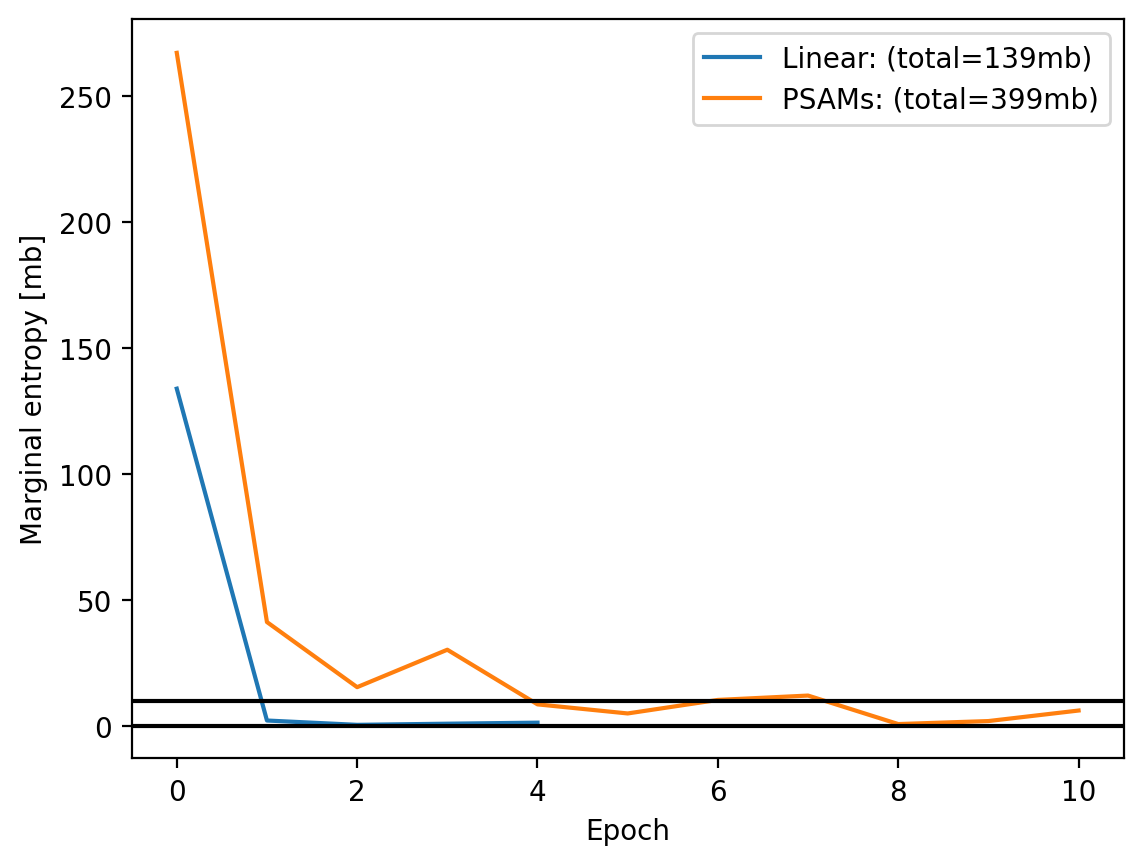

In [7]:
plt.figure(dpi=200)
plt.plot(results_mll * 1000, label=f"Linear: (total={results_mll.sum() * 1000:.0f}mb)")
plt.plot(results_psam * 1000, label=f"PSAMs: (total={results_psam.sum() * 1000:.0f}mb)")
plt.axhline(0, color="black")
plt.axhline(10, color="black")
plt.xlabel("Epoch")
plt.ylabel("Marginal entropy [mb]")
plt.legend()
plt.show()

In [8]:
from permacache import stable_hash

In [9]:
no_orf = stop_codon_psamdfa("TAG", "TAA", "TGA", zero_prob=ZeroProbability(1e-7)).cuda()
no_orf_ta = stop_codon_psamdfa("TAG", "TAA", zero_prob=ZeroProbability(1e-7)).cuda()

In [10]:
def plot_all_psams(gates_trained):
    _, axs = plt.subplots(
        len(gates_trained), 3, figsize=(10, 3 * len(gates_trained)), tight_layout=True
    )
    for g, axs_row in zip(gates_trained, axs):
        plot_linear_psam_gate(g, *axs_row)

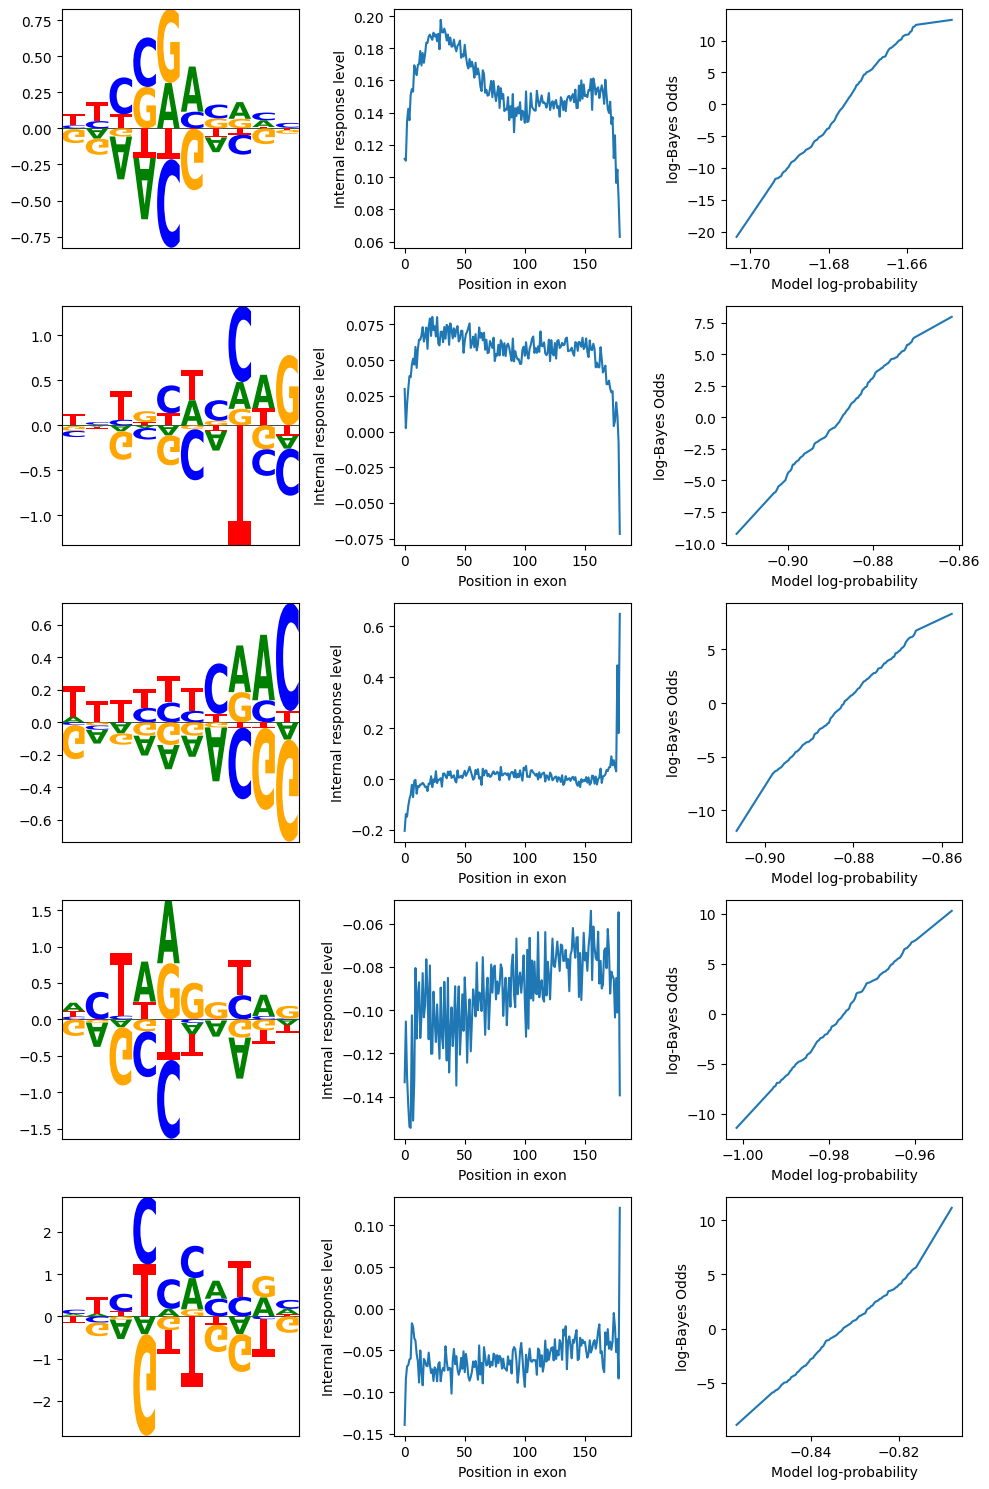

In [11]:
plot_all_psams(gates_psams[:5])

In [12]:
def pdfa_results(num_seeds, baselines):
    gates, train, results = zip(
        *(train_psamdfa(baselines, seed=seed) for seed in range(num_seeds))
    )
    return dict(
        gates=gates,
        last_gates=[g[-1] for g in gates],
        curves=-np.array(train)[:, 0, :, :].mean(-1),
        eva=[r[-1] for r in results],
    )

In [13]:
r_pdfa = pdfa_results(10, [])
r_pdfa_cp = pdfa_results(10, gates_psams)

Training gate 1/1
Training gate 1/1
Training gate 1/1
Training gate 1/1
Training gate 1/1
Training gate 1/1
Training gate 1/1
Training gate 1/1
Training gate 1/1
Training gate 1/1
Training gate 1/1
Training gate 1/1
Training gate 1/1
Training gate 1/1
Training gate 1/1
Training gate 1/1
Training gate 1/1
Training gate 1/1
Training gate 1/1
Training gate 1/1


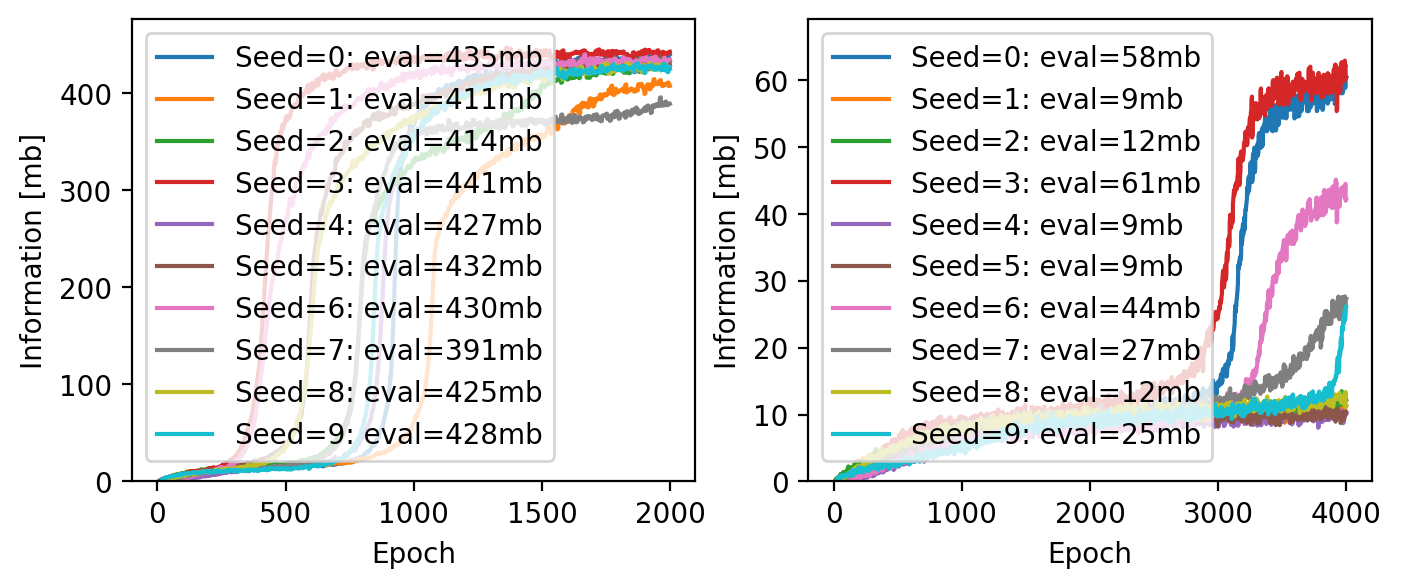

In [14]:
_, axs = plt.subplots(1, 2, figsize=(8, 3), dpi=200)
for ax, r, label in zip(
    axs,
    (r_pdfa, r_pdfa_cp),
    ("No control", "Control for linear"),
):
    for seed, (gate, x, result) in enumerate(
        zip(r["last_gates"], r["curves"], r["eva"])
    ):
        ax.plot(
            x * 1000,
            label=f"Seed={seed}: eval={1000 * result:.0f}mb",
        )
    ax.set_ylim(0, ax.set_ylim()[1])
    ax.legend()
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Information [mb]")

In [15]:
def just_plot_last(dfa, all_gates):
    ys = [1000 * train_pdfa_wrt_all(dfa, gates)[-1] for gates in all_gates]
    return [len(gates) for gates in all_gates], ys

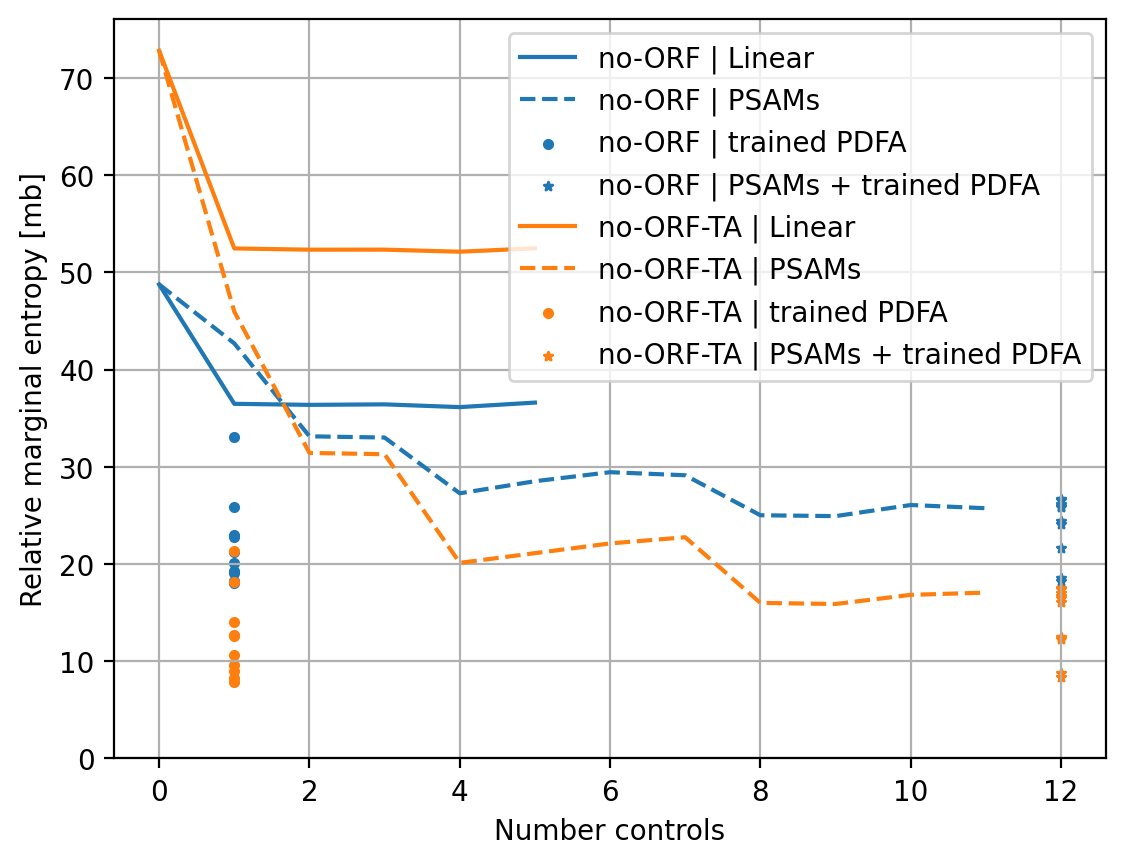

In [16]:
plt.figure(dpi=200)
for i, (dfa, label) in enumerate(zip((no_orf, no_orf_ta), ("no-ORF", "no-ORF-TA"))):
    plt.plot(
        1000 * train_pdfa_wrt_all(dfa, gates_mll),
        label=f"{label} | Linear",
        color=f"C{i}",
    )
    plt.plot(
        1000 * train_pdfa_wrt_all(dfa, gates_psams),
        label=f"{label} | PSAMs",
        color=f"C{i}",
        linestyle="--",
    )
    # control_for_trained_wrt_psams = [train_pdfa_wrt_all(dfa, gates)[-1] for gates in r_pdfa_cp["gates"]]
    # plt.scatter(len(r_pdfa_cp["gates"][0]) - 1, control_for_trained_wrt_psams)
    plt.scatter(
        *just_plot_last(dfa, r_pdfa["gates"]),
        label=f"{label} | trained PDFA",
        color=f"C{i}",
        marker=".",
    )
    plt.scatter(
        *just_plot_last(dfa, r_pdfa_cp["gates"]),
        label=f"{label} | PSAMs + trained PDFA",
        color=f"C{i}",
        marker="*",
        s=10,
    )

# plt.axhline(1000 * )
plt.ylim(0, plt.ylim()[1])
plt.legend()
plt.xlabel("Number controls")
plt.ylabel("Relative marginal entropy [mb]")
plt.grid()
plt.show()

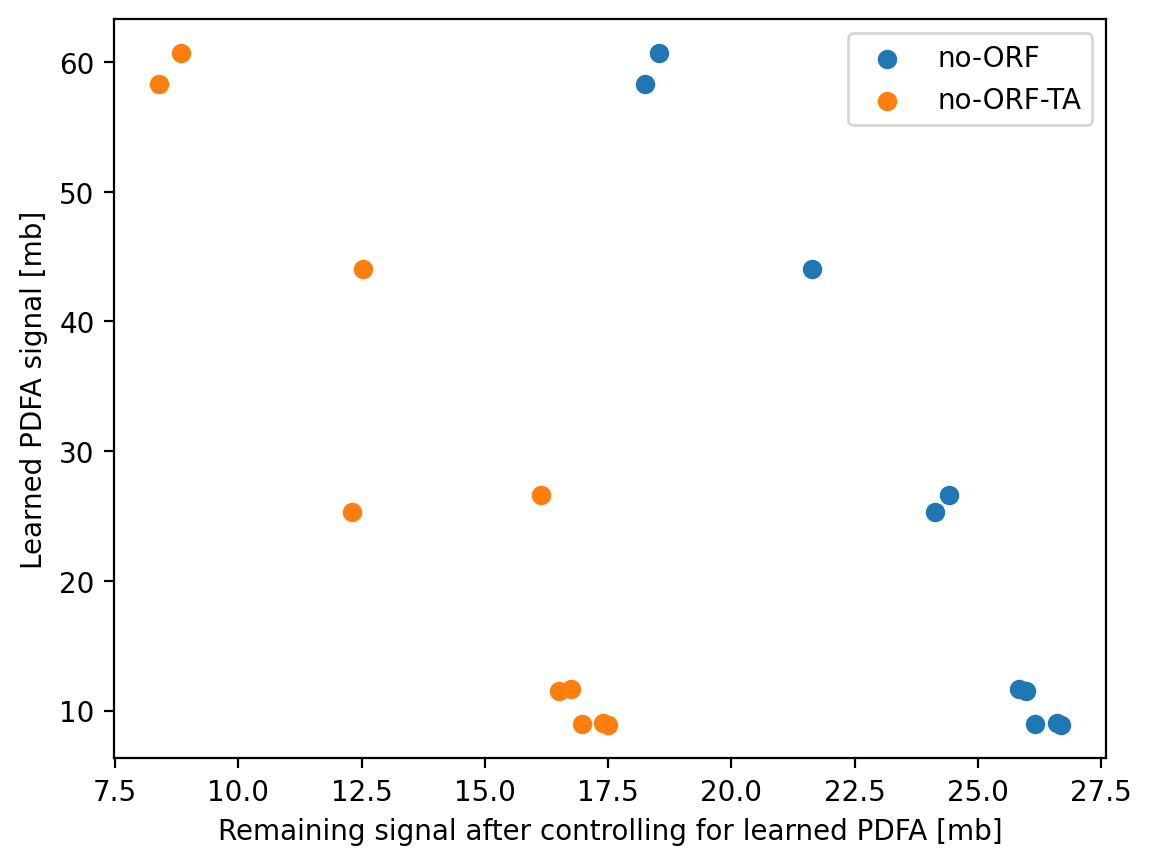

In [17]:
plt.figure(dpi=200)
plt.scatter(
    just_plot_last(no_orf, r_pdfa_cp["gates"])[-1],
    1000 * np.array(r_pdfa_cp["eva"]),
    label="no-ORF",
)
plt.scatter(
    just_plot_last(no_orf_ta, r_pdfa_cp["gates"])[-1],
    1000 * np.array(r_pdfa_cp["eva"]),
    label="no-ORF-TA",
)
plt.xlabel("Remaining signal after controlling for learned PDFA [mb]")
plt.ylabel("Learned PDFA signal [mb]")
plt.legend()
plt.show()

1 0.31779966 4@32%
2 0.4639168 4@46%
3 0.120624535 4@12%


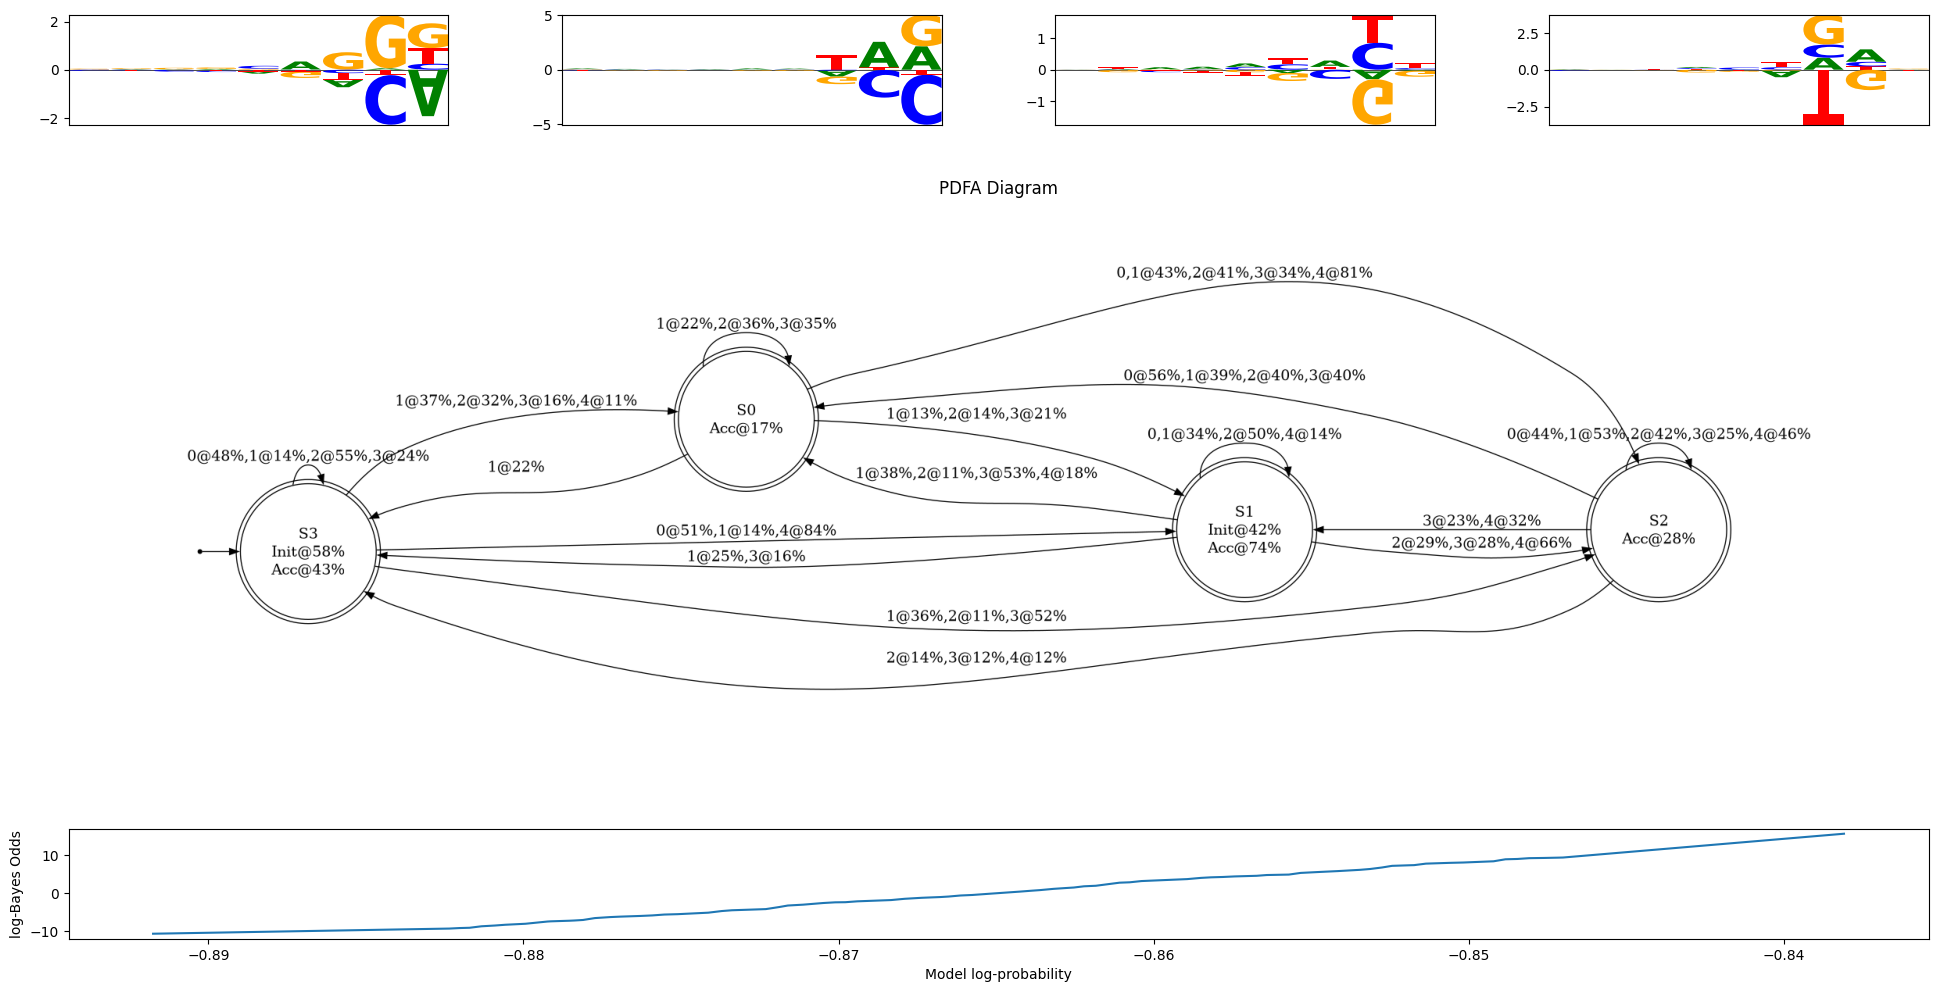

In [18]:
plot_pdfa(r_pdfa_cp["last_gates"][0])

0 0.36549264 4@37%
1 0.16271937 4@16%
2 0.1878051 4@19%
3 0.2839829 4@28%


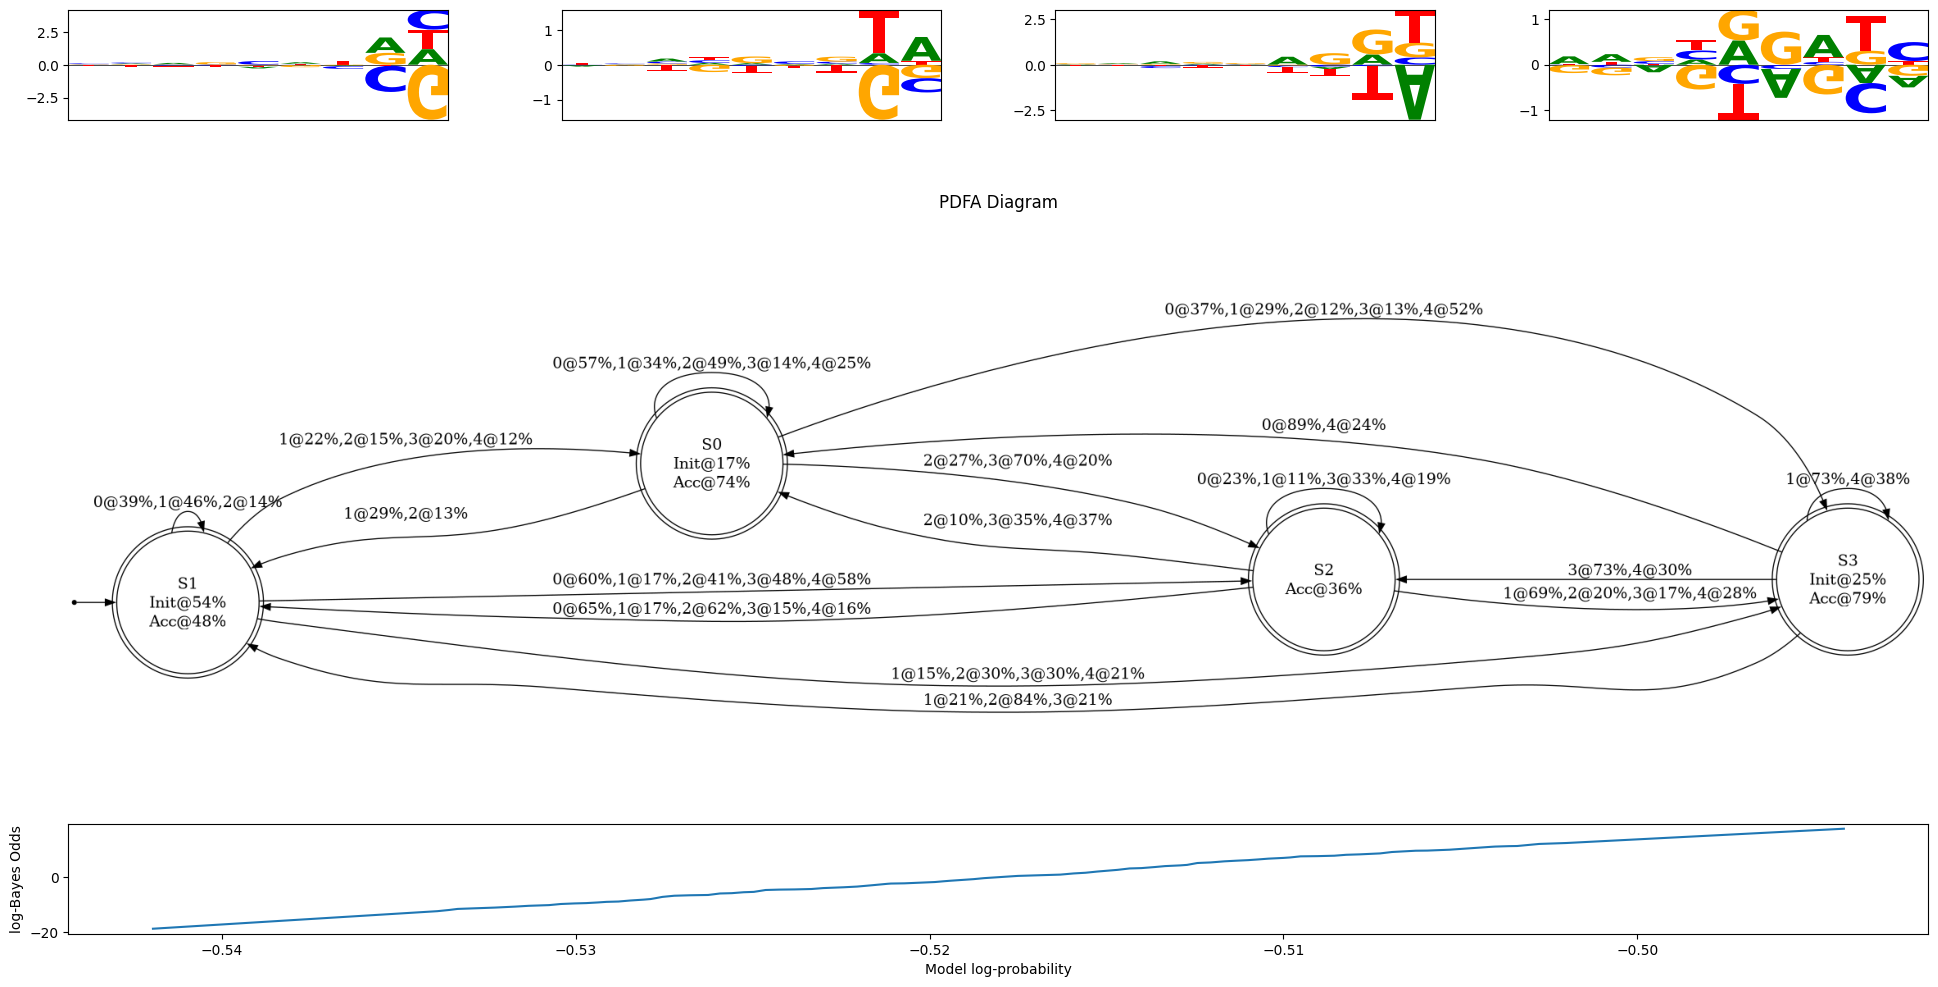

In [19]:
plot_pdfa(r_pdfa_cp["last_gates"][1])